In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import torch as T
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

In [7]:
from learners.gcm import GenerativeContrastiveModelling
from generate_trajectories import generate_data
from process_trajectories import data_to_tensors

In [9]:
learner = GenerativeContrastiveModelling(
            (3, 56, 56),
            128,
            128,
            True,
            True,
            False
        )

In [10]:
learner.encoder.load_checkpoint('/Users/ajelley/Projects/gen-con-rl/wandb/run-20220705_164807-2on3lyxa/files')

Loading state encoder network checkpoint...


In [13]:
import minigrid_rl_starter.utils as utils
# Load environment

env = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 0)
for _ in range(0):
    env.reset()
env_copy = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 0)
for _ in range(0):
    env_copy.reset()
print("Environment loaded\n")

# Load agent

trained_model_dir = utils.get_model_dir("CrossingS11N5_A2C_fullgrid_navigation", storage_dir="minigrid_rl_starter")
exploratory_model_dir = utils.get_model_dir("CrossingS11N5_A2C_fullgrid_navigation_state_bonus", storage_dir="minigrid_rl_starter")

trained_agent = utils.Agent(
    env.observation_space,
    env.action_space,
    trained_model_dir,
    argmax=True,
    use_memory=False,
    use_text=False,
)
print("Trained agent loaded\n")

exploratory_agent = utils.Agent(
    env.observation_space,
    env.action_space,
    exploratory_model_dir,
    argmax=True,
    use_memory=False,
    use_text=False,
)
print("Exploratory agent loaded\n")

Environment loaded

Trained agent loaded

Exploratory agent loaded



In [ ]:
train_dataset = generate_data(env=env, agent=trained_agent, episodes=5, render=False)

In [ ]:
train_trajectories = data_to_tensors(train_dataset)
environments = F.interpolate(T.Tensor(
            np.array([train_dataset[episode][0]["obs"]["pixels"] for episode in train_dataset])
        ), size=32)

In [ ]:
means, precisions = learner.encoder.forward(train_trajectories['observations'], train_trajectories['locations'], train_trajectories['directions'])

In [ ]:
means[:21].shape

In [ ]:
plt.imshow(means[train_trajectories['targets']==3].detach().numpy())

In [ ]:
len(train_trajectories['targets'][train_trajectories['targets']==1])

In [ ]:
T.argmax(precisions[22])

In [ ]:
plt.imshow(environments[2].permute(1,2,0)/255.0)

In [ ]:
plt.imshow(environments[0].permute(1,2,0)/255.0)

In [2]:
from models.environment_decoder import EnvironmentDecoder

In [11]:
decoder = EnvironmentDecoder(128, 128, (3,32,32))
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

In [ ]:
decoder.forward(means, precisions).shape

Episode: 0, 	Loss: 0.10079357028007507


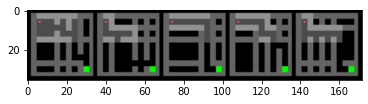

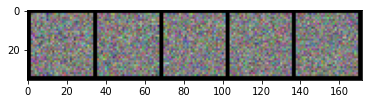

Episode: 10, 	Loss: 0.06613945215940475


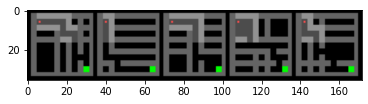

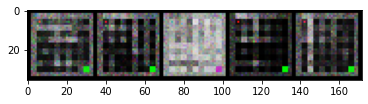

Episode: 20, 	Loss: 0.03798334673047066


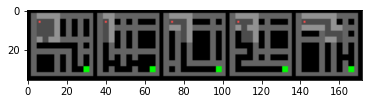

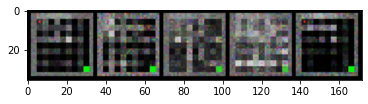

Episode: 30, 	Loss: 0.02428535558283329


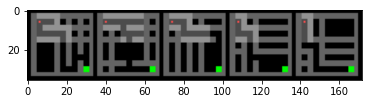

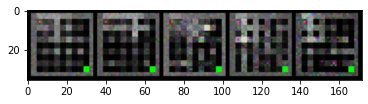

Episode: 40, 	Loss: 0.023654380813241005


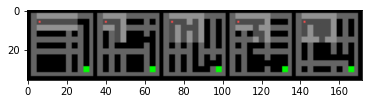

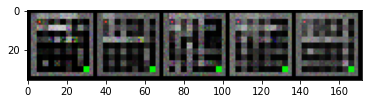

Episode: 50, 	Loss: 0.027041204273700714


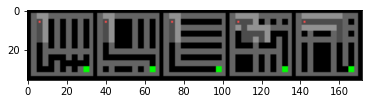

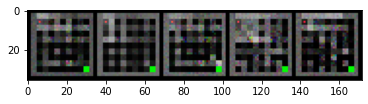

Episode: 60, 	Loss: 0.03009616583585739


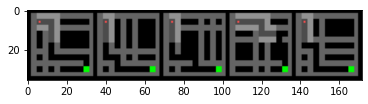

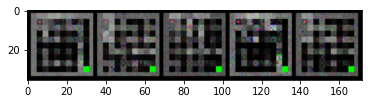

Episode: 70, 	Loss: 0.028966836631298065


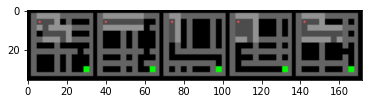

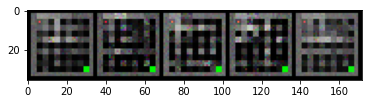

KeyboardInterrupt: 

In [17]:
for episode in range(10000):
    train_dataset = generate_data(env=env, agent=trained_agent, episodes=5, render=False)
    train_trajectories = data_to_tensors(train_dataset, device='cpu')
    environments = F.interpolate(T.Tensor(
                np.array([train_dataset[episode][0]["obs"]["pixels"] for episode in train_dataset])
            ), size=32)/255.0

    means, precisions = learner.encoder.forward(train_trajectories['observations'], train_trajectories['locations'], train_trajectories['directions'], coordinates=None)
    means=means.unsqueeze(0).detach()
    precisions=precisions.unsqueeze(0).detach()
    (env_proto_means,
    env_proto_precisions,
    log_env_proto_normalisation,
    ) = learner.inner_gaussian_product(
        means, precisions, train_trajectories['targets'].unsqueeze(0)
        )

    env_reconstructions = decoder.forward(env_proto_means.squeeze(), env_proto_precisions.squeeze())
    reconstruction_loss = F.mse_loss(env_reconstructions, environments)

    decoder_optimizer.zero_grad()
    reconstruction_loss.backward()
    decoder_optimizer.step()

    if episode%10==0:
        print(f'Episode: {episode}, \tLoss: {reconstruction_loss}')
        plt.imshow(torchvision.utils.make_grid(environments).permute(1,2,0))
        plt.show()
        plt.imshow(torchvision.utils.make_grid(env_reconstructions).permute(1,2,0))
        plt.show()

In [16]:
for episode in range(1000):
    train_dataset = generate_data(env=env, agent=trained_agent, episodes=5, render=False)
    train_trajectories = data_to_tensors(train_dataset)
    environments = F.interpolate(T.Tensor(
                np.array([train_dataset[episode][step]["obs"]["partial_pixels"] for episode in train_dataset for step in train_dataset[episode]])
            ), size=32)/255.0

    means, precisions = learner.encoder.forward(train_trajectories['observations'], train_trajectories['locations'], train_trajectories['directions'])
    means=means.unsqueeze(0).detach()
    precisions=precisions.unsqueeze(0).detach()
    # (env_proto_means,
    # env_proto_precisions,
    # log_env_proto_normalisation,
    # ) = learner.inner_gaussian_product(
    #     means, precisions, train_trajectories['targets'].unsqueeze(0)
    #     )

    env_reconstructions = decoder.forward(means.squeeze(), precisions.squeeze())
    reconstruction_loss = F.mse_loss(env_reconstructions, environments)

    decoder_optimizer.zero_grad()
    reconstruction_loss.backward()
    decoder_optimizer.step()

    if episode%10==0:
        print(f'Episode: {episode}, \tLoss: {reconstruction_loss}')
        plt.imshow(torchvision.utils.make_grid(environments[:5]).permute(1,2,0))
        plt.show()
        plt.imshow(torchvision.utils.make_grid(env_reconstructions[:5]).permute(1,2,0))
        plt.show()

TypeError: data_to_tensors() missing 1 required positional argument: 'device'

In [ ]:
import copy
initial_decoder = copy.deepcopy(decoder)

In [ ]:
T.ones(4,100)[:,-6:].shape

In [5]:
from generative_contrastive_modelling.unsupervised_gcm import UnsupervisedGenerativeContrastiveModelling
learner = UnsupervisedGenerativeContrastiveModelling(
            input_shape=(3, 56, 56),
            hid_dim=128,
            z_dim=128
            prior_precision=0.01,
            use_location=F
            use_direction=config.use_direction,
            use_coordinates=False,
        )

In [ ]:
precisions = np.logspace(-5, 5, 50)
log_likelihoods = []